# Downloading libraries

In [1]:
# import the necessary packages

#!pip install imutils
#!pip install opencv-python
#!pip install sklearn
#!pip install numpy
#!pip install nltk
#!pip install pathlib
#!pip install seaborn
#!pip install imblearn
#!pip install tensorflow


# Import the necessary packages

In [2]:
    import datetime as dt
    import matplotlib.pyplot as plt
    import nltk
    import numpy as np
    import os
    import pandas as pd 
    import pathlib
    import re
    import seaborn as sns
    import string
    import time
    import warnings
    
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import NearMiss
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.under_sampling import TomekLinks
    from imblearn.datasets import make_imbalance
    
    import tensorflow.compat.v1 as tf
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.layers import Embedding
    from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
    from tensorflow.keras.optimizers import SGD
    
    from keras import callbacks
    from keras.layers import Dense, Embedding, LSTM, GRU, Flatten,GlobalMaxPooling1D, Input
    from keras.layers.core import Activation, Dropout, Dense
    from keras.layers.embeddings import Embedding
    from keras.models import Sequential
    
    from nltk.corpus import stopwords
    from numpy import array
    from sklearn import metrics
    from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
    from sklearn.model_selection import train_test_split
    from sklearn.utils import class_weight
    from collections import Counter
    
    
    plt.style.use('ggplot')
    
    # ignoring all the warnings
    #warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore")

    # downloading stopwords corpus
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('vader_lexicon')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('movie_reviews')
    nltk.download('punkt')
    nltk.download('conll2000')
    nltk.download('brown')
    stopwords = set(stopwords.words("english"))
    
    # for showing all the plots inline
    %matplotlib inline

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Raj\AppData\Roaming\nltk_data...
[nltk_data]   Packag

# Common Functions 

In [3]:
# function to get unique values 
def unique(list1):
    
    global unique_list
          
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    #for x in unique_list: 
        #print(x)
        
def plot_history(history):
        
#dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training Accuracy')
    plt.plot(x, val_acc, 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Model Loss')
    plt.legend()



print(__doc__)
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct, v=val)
        return my_autopct

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct=make_autopct(sizes))
    ax.axis('equal')

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

Automatically created module for IPython interactive environment


# Data Exploration

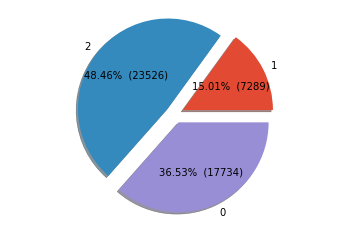

In [4]:
all_ticket_df = pd.read_csv('all_tickets_processed_3topics.csv')

# display updated DataFrame
all_ticket_df.head()

labels = all_ticket_df['Target']
samples = all_ticket_df['body']

plot_pie(labels)


# Training and Test DataSets

In [5]:
x1 = []
sentences = list(samples)
for sen in sentences:
    x1.append(preprocess_text(sen))

y = labels

x_train, x_test, y_train, y_test = train_test_split(x1, y, test_size=0.15, random_state=42)


# Load Embedding
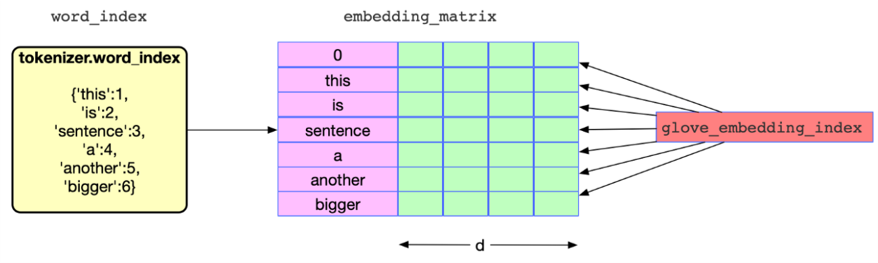

In [6]:

vectorizer = TextVectorization(max_tokens=50000, output_sequence_length=1000)
text_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
path_to_glove_file = 'glove.840B.300d.txt'
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0
embeddings_index = {}

with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word.decode("utf-8"))
    if embedding_vector is not None and len(embedding_vector)>0:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Found 2195884 word vectors.
Converted 11761 words (10 misses)


# Build Model - Convolutional Neural Network (CNN)
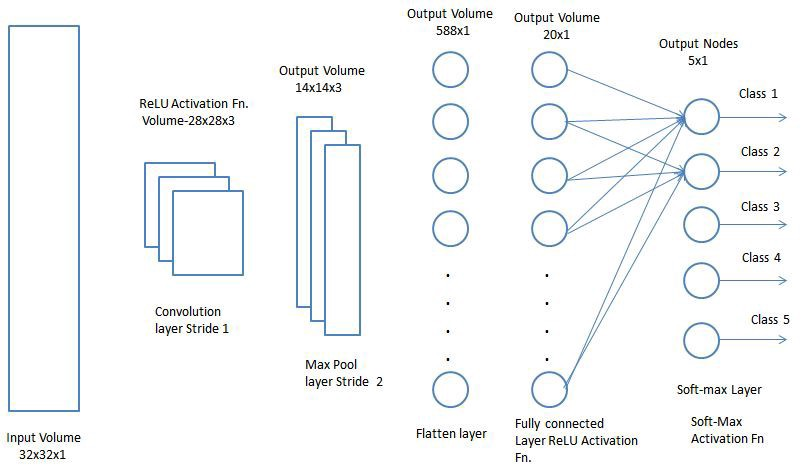

In [7]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    #embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    embeddings_initializer=keras.initializers.RandomUniform(embedding_matrix),
    trainable=False,
)


int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
       
preds = layers.Dense(len(labels), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         3531900   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         192128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         82048 

DataSet before imbalanced fix...........
Training Data Shape(x,y):--------------> (41266, 1000) (41266,)
Test Data Shape(x,y):------------------> (7283, 1000) (7283,)


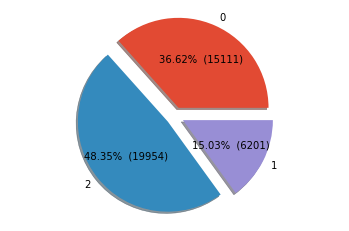

In [8]:
#Vectorization

x_train = vectorizer(np.array([[s] for s in x_train])).numpy()
x_test = vectorizer(np.array([[s] for s in x_test])).numpy()

y_train = np.array(y_train)
y_test = np.array(y_test)

#Before imbalanced fix
print("DataSet before imbalanced fix...........")
print("Training Data Shape(x,y):-------------->", x_train.shape, y_train.shape)
print("Test Data Shape(x,y):------------------>", x_test.shape, y_test.shape)
plot_pie(y_train)


# Fixing Imbalanced DataSet 

------------------------------------------------
DataSet after imbalanced fix...........
Training Data Shape(x,y):--------------> (41266, 1000) (41266,)
Test Data Shape(x,y):------------------> (7283, 1000) (7283,)


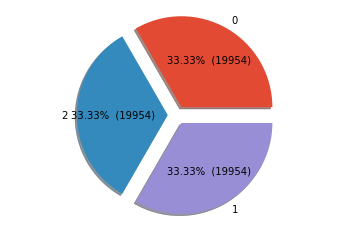

In [9]:
# Imbalanced Fix 

#- Synthetic Minority Oversampling Technique (SMOTE) - not working
#smote = SMOTE()
#x_train_im, y_train_im = smote.fit_resample(x_train, y_train)

#NearMiss -not working
#nm = NearMiss()
#x_train_im, y_train_im = nm.fit_resample(x_train, y_train)

#sampling_strategy2 = 'not majority'
#rus2 = RandomUnderSampler(sampling_strategy=sampling_strategy2)
#x_train_im, y_train_im = rus2.fit_resample(x_train, y_train)

#rus3 = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
#x_train_im, y_train_im = rus3.fit_resample(x_train, y_train)

#Random under-sampling with imblearn
sampling_strategy1 = 'not majority'
rus1 = RandomOverSampler(sampling_strategy=sampling_strategy1)
x_train_im, y_train_im = rus1.fit_resample(x_train, y_train)


print("------------------------------------------------")
print("DataSet after imbalanced fix...........")
print("Training Data Shape(x,y):-------------->", x_train.shape, y_train.shape)
print("Test Data Shape(x,y):------------------>", x_test.shape, y_test.shape)
plot_pie(y_train_im)

# Fine-tuning and Compile Model 

In [10]:
#Optimization Parameters

NUM_EPOCHS = 20 #Number of epoch
INIT_LR = 0.01 #Learning Rate
BS = 32 #Batch Size

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=10000,
    decay_rate=0.9
    )

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)


model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])

class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)


#  Training Model

In [11]:
#Early Stopping

earlystopping = callbacks.EarlyStopping(monitor ="val_loss",mode ="min", patience = 1,restore_best_weights = True) 


#Model Training/ Fitting

#history = model.fit(x_train_im, y_train_im, batch_size=BS,epochs=NUM_EPOCHS,validation_data=(x_test, y_test),
#                    class_weight=class_weight,
#                    callbacks =[earlystopping])

history = model.fit(x_train_im, y_train_im, batch_size=BS,epochs=NUM_EPOCHS,validation_split = 0.15,
                    class_weight=class_weight,
                    callbacks =[earlystopping])


Train on 50882 samples, validate on 8980 samples
Epoch 1/20
50882/50882 [==============================] - 164s 3ms/sample - loss: 1.1415 - sparse_categorical_accuracy: 0.4832 - val_loss: 0.6913 - val_sparse_categorical_accuracy: 0.6371
Epoch 2/20
50882/50882 [==============================] - 157s 3ms/sample - loss: 0.5453 - sparse_categorical_accuracy: 0.7795 - val_loss: 0.3449 - val_sparse_categorical_accuracy: 0.8723
Epoch 3/20
50882/50882 [==============================] - 152s 3ms/sample - loss: 0.3593 - sparse_categorical_accuracy: 0.8626 - val_loss: 0.2340 - val_sparse_categorical_accuracy: 0.9190
Epoch 4/20
50882/50882 [==============================] - 157s 3ms/sample - loss: 0.2552 - sparse_categorical_accuracy: 0.9055 - val_loss: 0.3774 - val_sparse_categorical_accuracy: 0.8376


# Evaluate Your Model Performance

Evaluate model Training Data......................
Evaluate model Test Data..........................
                                                       
Training Accuracy: 84.0725
Testing Accuracy:  84.0725
                                                       


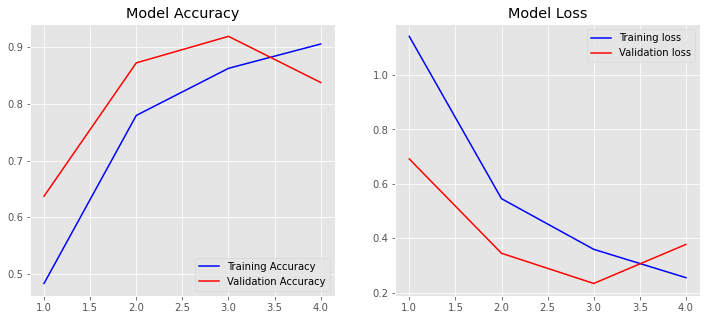

In [12]:

# evaluate the model
print('Evaluate model Training Data......................')
loss, accuracy = model.evaluate(x_train_im, y_train_im, verbose=False)
print('Evaluate model Test Data..........................')
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print('                                                       ')
print("Training Accuracy: {:.4f}".format(accuracy*100))
print("Testing Accuracy:  {:.4f}".format(accuracy*100))
print('                                                       ')
    
#print(history.history.keys())
plot_history(history)
    

# Prediction

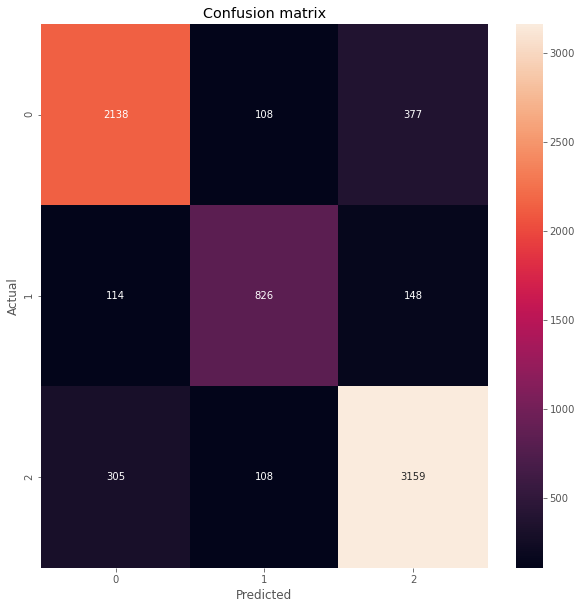

In [13]:
#Predict

y_pred = model.predict(x_test)

conf_mat = confusion_matrix(y_test, np.argmax(y_pred, axis = 1))

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True,fmt='g',xticklabels=pd.Series(all_ticket_df['Target'].unique()).sort_values(), 
            yticklabels=pd.Series(all_ticket_df['Target'].unique()).sort_values(ascending=True))

plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# Clssification Report

In [14]:
target_name = unique(all_ticket_df['Target'])
print(metrics.classification_report(y_test, np.argmax(y_pred, axis = 1), target_names=target_name))


              precision    recall  f1-score   support

           0       0.84      0.82      0.83      2623
           1       0.79      0.76      0.78      1088
           2       0.86      0.88      0.87      3572

    accuracy                           0.84      7283
   macro avg       0.83      0.82      0.82      7283
weighted avg       0.84      0.84      0.84      7283



In [ ]:
import shap
from keras.datasets import imdb

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, x_train[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs

arr = np.array(x_train[:1]).tolist()
shap_values = explainer.shap_values(x_train[:10],int)

# init the JS visualization code
shap.initjs()

# transform the indexes to words
import numpy as np
words = imdb.get_word_index()
num2word = {}
for w in words.keys():
    num2word[words[w]] = w
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), x_test[i]))) for i in range(10)])

# plot the explanation of the first prediction
# Note the model is "multi-output" because it is rank-2 but only has one column
shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test_words[0])

